Current notebook is using random forest as algorithm for - titanic spaceship

We want to achieve more accuracy then logistical regression ( 0.78 ) 

It would be interesting to see if we can get better confusion matrix and  auc value using random forest

In [1]:
import common_functions as cfs
import random_forest as ranf
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
from sklearn.metrics import roc_curve, auc
# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [2]:
# reading the training data
df = pd.read_csv("C:\\Users\\u725561\\machine-learning\\spaceship-titanic\\train.csv")

In [3]:
df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


Check how many unique Homeplanets are present . Idea is to see , if HomePlanet is category field or numeric field 

As suspected it is a categorical field .

It has value of 'Europa', 'Earth', 'Mars' , nan . 

In [4]:
df.HomePlanet.unique()

array(['Europa', 'Earth', 'Mars', nan], dtype=object)

Perform data manipulation . 

* create new columns out of composite columns  , 'PassengerId' and 'Cabin' columns

  PassengerId column will split into 2 new columns Group , NumInGroup

   Cabin column will split into 3 new columns CabinDeck , CabinNum , CabinSide

* handles missing values


In [5]:
cfs.split_and_createnewcol(df)

Observe the new columns are created 

In [6]:
df

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Group,NumInGroup,CabinDeck,CabinNum,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,01,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,01,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,01,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,02,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,01,F,1,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,False,9276,01,A,98,P
8689,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,False,9278,01,G,1499,S
8690,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,True,9279,01,G,1500,S
8691,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,False,9280,01,E,608,S


In [7]:
# check the distribution of Cabin Deck . Seems F , G are more frequent
df.CabinDeck.value_counts()

CabinDeck
F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: count, dtype: int64

In [8]:
df.CabinNum.info()

<class 'pandas.core.series.Series'>
RangeIndex: 8693 entries, 0 to 8692
Series name: CabinNum
Non-Null Count  Dtype
--------------  -----
8693 non-null   int32
dtypes: int32(1)
memory usage: 34.1 KB


In [9]:
df.CabinNum.value_counts()

CabinNum
82      29
86      23
19      22
176     21
97      21
        ..
1669     1
779      1
1547     1
1663     1
1894     1
Name: count, Length: 1817, dtype: int64

In [10]:
# find total number of NaN values in the column CabinNum
df.CabinNum.isna().sum()

0

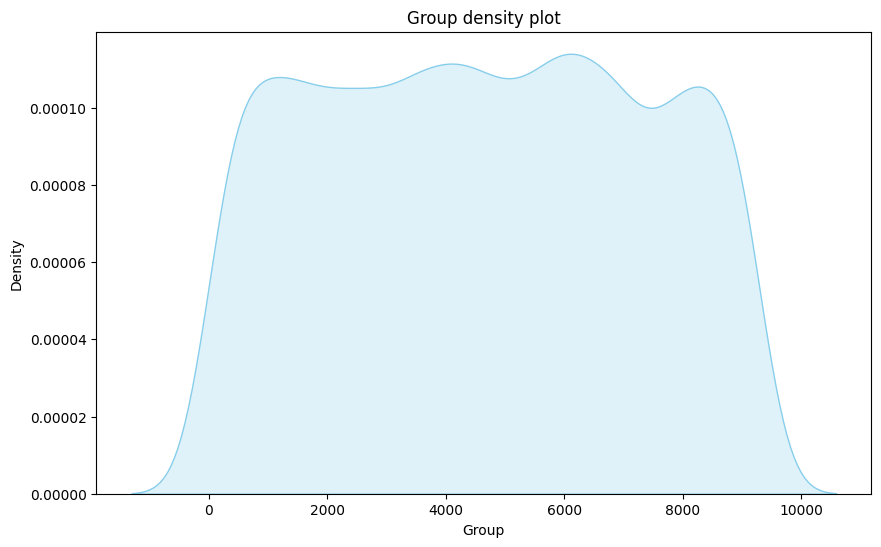

In [11]:
# check the frequency distribution for Group column. looks evenly distributed
cfs.plot_kde('Group',df,'Group density plot')

In [12]:
# Observe CabinNum is object , which is string , need to convert to int
df.dtypes

HomePlanet       object
CryoSleep        object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Transported        bool
Group             int32
NumInGroup       object
CabinDeck        object
CabinNum          int32
CabinSide        object
dtype: object

In [13]:
# observed that CabinNum 82 has frequency unchanged /not changed much
df.CabinNum.value_counts()

CabinNum
82      29
86      23
19      22
176     21
97      21
        ..
1669     1
779      1
1547     1
1663     1
1894     1
Name: count, Length: 1817, dtype: int64

In [14]:
# check the distribution of CabinSide . It has only 2 unique values S and P . Probably should drop ?
df.CabinSide.value_counts()

CabinSide
S    4288
P    4206
Name: count, dtype: int64

In [15]:
# Check whether the target variable is distributed uniformly . would observe that almost evenly distributed
df.Transported.value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

In [16]:
# extract target column into a numpy array . This would go into fit as argument 
y = cfs.extract_target_column(df,"Transported")
y

array([0, 1, 0, ..., 1, 0, 1])

In [17]:
df.shape

(8693, 15)

In [18]:
df.Destination.unique()

array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e', nan], dtype=object)

In [19]:
null_columns = df.columns[df.isna().any()].tolist()
print(null_columns)

['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CabinDeck', 'CabinSide']


In [20]:
# Separate features into numerical and categorical
numerical_features = df.select_dtypes(include=['float64','int32']).columns
print(f"numerical features {numerical_features}")
categorical_features = df.select_dtypes(include=['object']).columns
print(f"categorical features {categorical_features}")

numerical features Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Group', 'CabinNum'],
      dtype='object')
categorical features Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'NumInGroup',
       'CabinDeck', 'CabinSide'],
      dtype='object')


Preprocess the dataframe 
* using scaler and imputer
* Both numeric and cate

In [21]:
X_preprocessed , feature_names = cfs.preprocess_dataframe(numerical_features, categorical_features, df)

In [22]:
# check that preprocessing has increased the number of coluns
X_preprocessed.shape

(8693, 36)

In [23]:
X_preprocessed_df = pd.DataFrame(data=X_preprocessed, columns=feature_names)

# Display the preprocessed DataFrame
print(X_preprocessed_df)

      num__Age  num__RoomService  num__FoodCourt  num__ShoppingMall  num__Spa  \
0     0.709437         -0.340590       -0.287314          -0.290817 -0.276663   
1    -0.336717         -0.175364       -0.281669          -0.248968  0.211505   
2     2.034566         -0.275409        1.955616          -0.290817  5.694289   
3     0.290975         -0.340590        0.517406           0.330225  2.683471   
4    -0.894666          0.118709       -0.243409          -0.038048  0.225732   
...        ...               ...             ...                ...       ...   
8688  0.848924         -0.340590        3.989682          -0.290817  1.184286   
8689 -0.755179         -0.340590       -0.287314          -0.290817 -0.276663   
8690 -0.197230         -0.340590       -0.287314           2.842851 -0.275774   
8691  0.221232         -0.340590        0.370637          -0.290817  0.037223   
8692  1.058155         -0.149594        2.653082          -0.290817 -0.276663   

      num__VRDeck  num__Gro

In [24]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

Use *Random forest classifier* 
* Logistical regression give accuracy of 0.780
* Random forest is expected to behave better . I see that it doing slightly better but not much better 0.788
* Also check precision/recall , F1-score

In [25]:
# Initialize the classifier
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=2, n_jobs=-1)

# Obtain scores of cross-validation
scores = cross_val_score(rf, X_train, y_train, cv=5)

# Display accuracy
print('Accuracy:', np.round(scores, 3))

# Display mean accuracy
print('Accuracy mean: %0.3f' % (scores.mean()))

Accuracy: [0.807 0.813 0.794 0.802 0.801]
Accuracy mean: 0.803


In [26]:
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)

In [27]:
# Display oob_score
rf.oob_score_

0.8050043140638481

In [28]:
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.79      0.82      0.80       861
           1       0.82      0.78      0.80       878

    accuracy                           0.80      1739
   macro avg       0.80      0.80      0.80      1739
weighted avg       0.80      0.80      0.80      1739



In [29]:
accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy on full dataset {accuracy}")

accuracy on full dataset 0.8016101207590569


More than accuracy , confusion matrix is also important to check , how is the confusion matrix 
* TPR and FPR - true positive and false positive 

In [30]:
cm = confusion_matrix(y_test,y_pred)

In [31]:
tp = cm[1,1]
fp = cm[0,1]
fn = cm[1,0]
print(f"true positive : {tp}")
print(f"false positive : {fp}")
print(f"false negative : {fn}")


true positive : 685
false positive : 152
false negative : 193


print the confusion matrix 
compare with that of logistic regression .
for logistic regression it is 
647,214
167,711


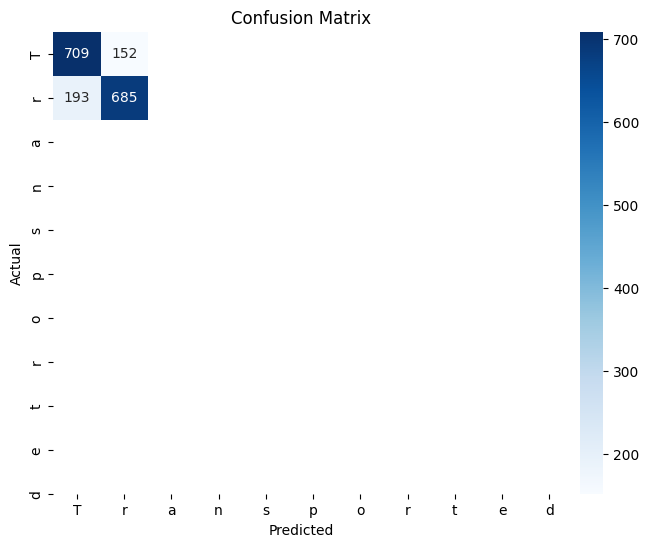

In [32]:
# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels='Transported', yticklabels='Transported')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### Print receiver operator characteristic
* Logistic regression - roc curve 0.87
* Random forest - roc curve 0.86 with n_estimators = 10
* Random forest - roc curve 0.88 with n_estimators = 50

Random forest is not currently better than Logistic regression with current model

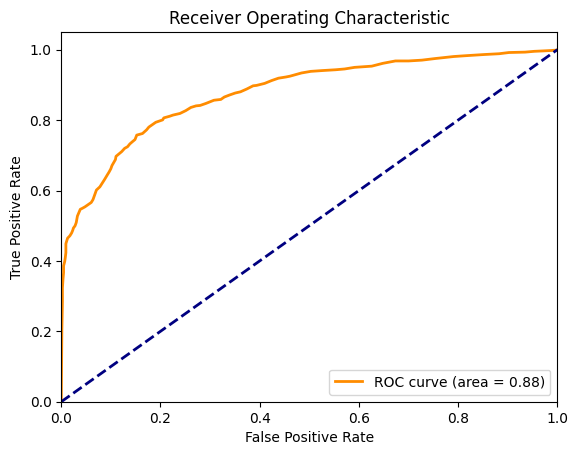

In [33]:
# Predict probabilities
y_probs = rf.predict_proba(X_test)[:, 1]
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

### Use Randomized grid search
We will try to tune the hyperparameters of random forest using Randomized grid search 

In [51]:
rf_grid = RandomForestClassifier( n_jobs=-1, random_state=2)

In [56]:
best_rf_model, y_pred = ranf.randomized_search_class(X_train,y_train,X_test,y_test, params={'min_weight_fraction_leaf':[0.0, 0.0025, 0.005, 0.0075, 0.01, 0.05],
                          'min_samples_split':[2, 0.01, 0.02, 0.03, 0.04, 0.06, 0.08, 0.1],
                          'min_samples_leaf':[1,2,4,6,8,10,20,30],
                          'min_impurity_decrease':[0.0, 0.01, 0.05, 0.10, 0.15, 0.2],
                          'max_leaf_nodes':[10, 15, 20, 25, 30, 35, 40, 45, 50, None],
                          'max_features':[ 0.8, 0.7, 0.6, 0.5, 0.4],
                          'max_depth':[None,2,4,6,8,10,20],
                          'n_estimators': [ 75,90,100]                                                                    
                         },scoring='f1',reg=rf_grid,runs=16)

Best params: {'n_estimators': 100, 'min_weight_fraction_leaf': 0.0025, 'min_samples_split': 0.01, 'min_samples_leaf': 2, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 30, 'max_features': 0.8, 'max_depth': 10}
Training score: 0.806
report post randomised grid search on best model - Validation data :
               precision    recall  f1-score   support

           0       0.82      0.73      0.77       861
           1       0.76      0.84      0.80       878

    accuracy                           0.79      1739
   macro avg       0.79      0.79      0.79      1739
weighted avg       0.79      0.79      0.79      1739



In [57]:
cm_rf = confusion_matrix(y_test,y_pred)

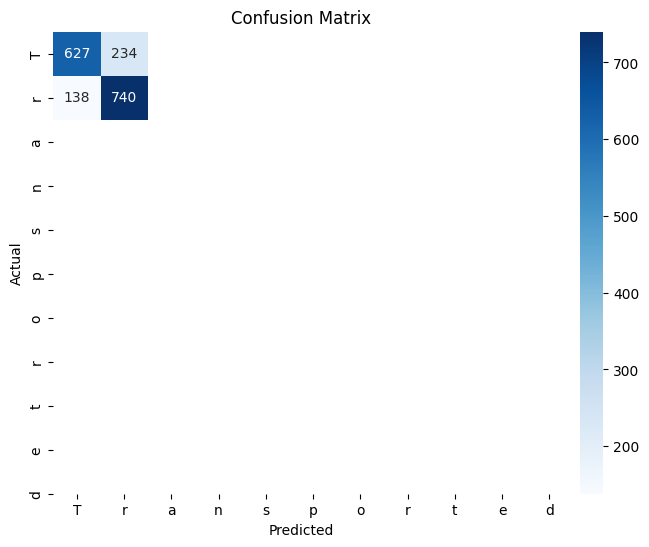

In [58]:
# plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap='Blues', xticklabels='Transported', yticklabels='Transported')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

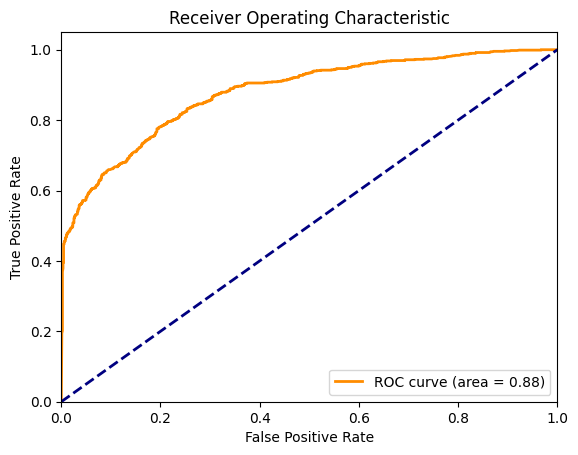

In [59]:
# Predict probabilities
y_probs = best_rf_model.predict_proba(X_test)[:, 1]
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)
# Plotting
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [62]:
# perform evaluation on test data 
df_test = pd.read_csv("C:\\Users\\u725561\\machine-learning\\spaceship-titanic\\test.csv")

In [63]:
keycol_df = pd.DataFrame()
keycol_df["PassengerId"] = df_test["PassengerId"]

In [65]:
cfs.split_and_createnewcol(df_test)

In [66]:
df_test

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Group,NumInGroup,CabinDeck,CabinNum,CabinSide
0,Earth,True,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,13,01,G,3,S
1,Earth,False,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,18,01,F,4,S
2,Europa,True,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,19,01,C,0,S
3,Europa,False,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,21,01,C,1,S
4,Earth,False,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,23,01,F,5,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,Earth,True,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,9266,02,G,1496,S
4273,Earth,False,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,9269,01,NaN,978,NaN
4274,Mars,True,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,9271,01,D,296,P
4275,Europa,False,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,9273,01,D,297,P


In [67]:
# Separate features into numerical and categorical
numerical_features = df_test.select_dtypes(include=['float64','int32']).columns
print(f"numerical features {numerical_features}")
categorical_features = df_test.select_dtypes(include=['object']).columns
print(f"categorical features {categorical_features}")

numerical features Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Group', 'CabinNum'],
      dtype='object')
categorical features Index(['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'NumInGroup',
       'CabinDeck', 'CabinSide'],
      dtype='object')


In [69]:
X_preprocessed_test , feature_names_test = cfs.preprocess_dataframe(numerical_features, categorical_features, df_test)

In [70]:
X_preprocessed_test.shape

(4277, 36)

In [71]:
# length of features 
len(feature_names_test)

36

In [72]:
# Make predictions on the test set
y_pred_test = best_rf_model.predict(X_preprocessed_test)

In [73]:
y_pred_test.shape

(4277,)

In [74]:
trans_df = pd.DataFrame({'Transported': y_pred_test})
trans_df['Transported'] = trans_df['Transported'].astype(bool)

In [75]:
# Concatenating DataFrames vertically based on columns
result_df = pd.concat([keycol_df, trans_df], axis=1)

In [76]:
result_df

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,True
4274,9271_01,True
4275,9273_01,True


In [77]:
# Save the DataFrame to a CSV file
result_df.to_csv('result_rf.csv', index=False)